In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob
import copy

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers=16)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44195/status,
Dashboard: /proxy/44195/status,Workers: 16
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40413,Workers: 16
Dashboard: /proxy/44195/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://10.0.128.171:41749,Total threads: 1
Dashboard: /proxy/41995/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:41543,


In [3]:
db = '/g/data/e14/rmh561/access-om2/archive/databases/cc_database_era5'
session = cc.database.create_session(db)

In [4]:
exptdict = OrderedDict([
#    ('1 JRA55 RYF',  {'expt':'1deg_jra55_ryf','cy':1,'color':'C0'}),
#    ('1 ERA5 RYF',  {'expt':'1deg_era5_ryf','cy':1,'color':'C1'}),
    ('1 JRA55 IAF',  {'expt':'1deg_jra55_iaf','cy':1,'color':'C2'}),
    ('1 ERA5 IAF',  {'expt':'1deg_era5_iaf','cy':1,'color':'C3'})
])

In [5]:
# WOA13 data:
WOA13 = xr.open_mfdataset('/g/data/ik11/observations/woa13/10_KDS50/woa13_ts_*')

## Just checking the final data for each expt.

In [6]:
for ekey in exptdict.keys():
    variable = 'temp_global_ave'
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session)
    start_year = var.time.isel(time=0)
    end_year = var.time.isel(time=-1)
    print(expt, start_year.values, end_year.values)

1deg_jra55_iaf 1980-01-02T00:00:00.000000000 1984-01-01T00:00:00.000000000
1deg_era5_iaf 1980-01-02T00:00:00.000000000 1982-01-01T00:00:00.000000000


## Scalar diagnostics

In [7]:
def plot_timeseries(variable,keys=exptdict.keys(),ncfile=None):
    plt.figure(figsize=(10,5))
    for ekey in keys:
        expt = exptdict[ekey]['expt']
        var = cc.querying.getvar(expt,variable,session,ncfile=ncfile)
        if (exptdict[ekey]['cy'] == 1):
            var.plot(label=ekey,color=exptdict[ekey]['color'])
        else:
            var.plot(color=exptdict[ekey]['color'])
    plt.xlabel('Time (years)')
    plt.legend()
    return

### Global Average Temperature

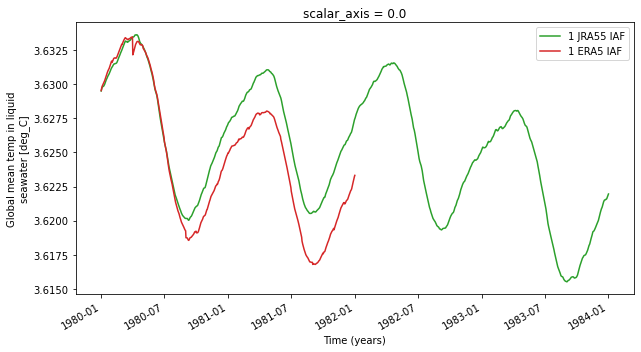

In [8]:
plot_timeseries('temp_global_ave')

### Global Average Salinity

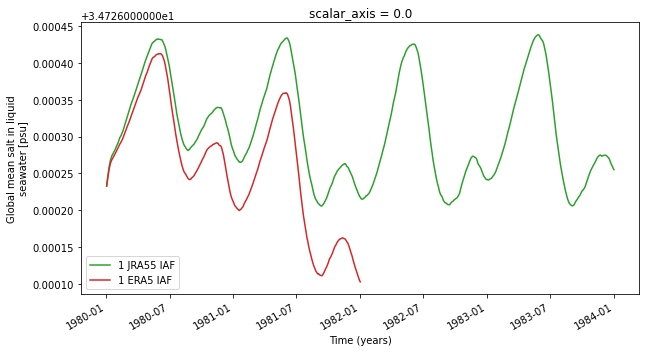

In [9]:
plot_timeseries('salt_global_ave')

### Surface Temperature

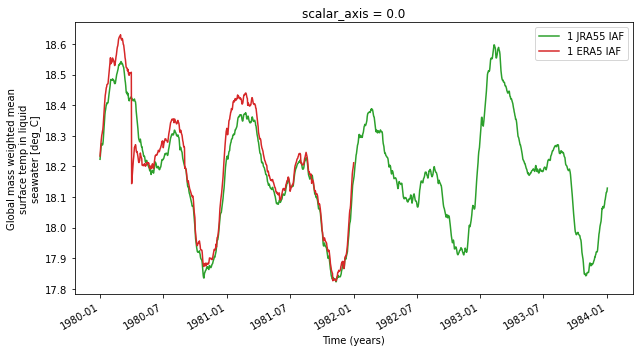

In [10]:
plot_timeseries('temp_surface_ave')

### Surface Salinity

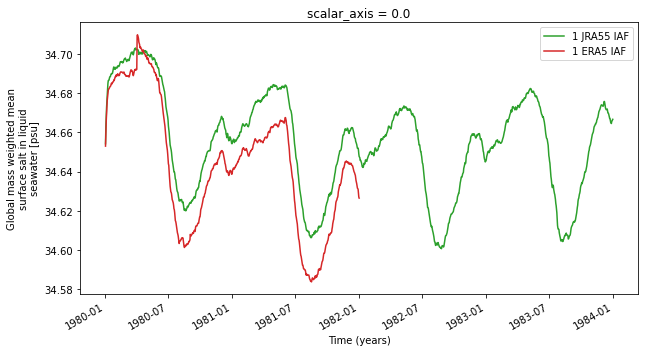

In [11]:
plot_timeseries('salt_surface_ave')

### Total Kinetic Energy

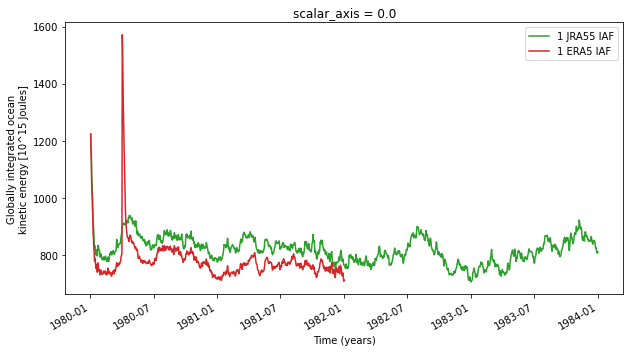

In [12]:
plot_timeseries('ke_tot')

## Area-Averaged Tracer Diagnostics

In [13]:
def plot_depthintv(variable,zlims,end_time='2200-01-01',keys=exptdict.keys()):
    plt.figure(figsize=(10,5))
    for ekey in keys:
        expt = exptdict[ekey]['expt']
        print(expt)
        var = cc.querying.getvar(expt,variable,session,end_time=end_time)
        area = cc.querying.getvar(expt,'area_t',session,n=1)
        dzt = cc.querying.getvar(expt,'dzt',session,n=1).isel(time=0)
        vol = (dzt*area).sel(st_ocean = slice(zlims[0],zlims[1]))
        var = var.sel(st_ocean = slice(zlims[0],zlims[1]))
        varmean = ((var*vol).sum('st_ocean').sum('yt_ocean').sum('xt_ocean')/(vol.sum('st_ocean').sum('yt_ocean').sum('xt_ocean')))
        (varmean-273.15).plot(label=ekey)
    plt.legend()
    plt.title(str(zlims[0]) + ' - ' + str(zlims[1]) + 'm ' + variable)

### Upper 700m temp

1deg_jra55_iaf
1deg_era5_iaf
CPU times: user 6.71 s, sys: 670 ms, total: 7.38 s
Wall time: 8.61 s


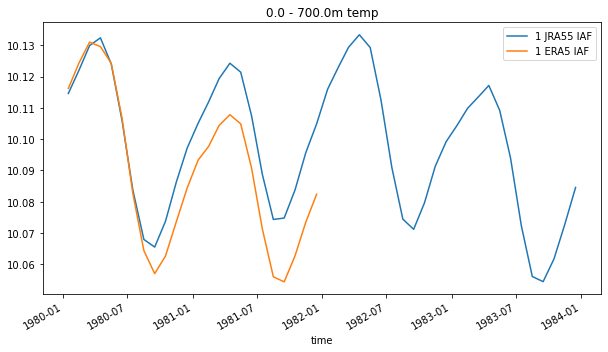

In [14]:
%%time
keys = exptdict.keys()
plot_depthintv('temp',[0.,700.],keys=keys)

### Upper 2000m temp

1deg_jra55_iaf
1deg_era5_iaf
CPU times: user 6.05 s, sys: 572 ms, total: 6.62 s
Wall time: 7.36 s


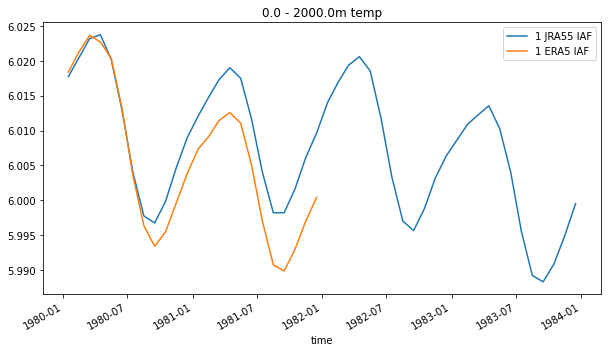

In [15]:
%%time
keys = exptdict.keys()
plot_depthintv('temp',[0.,2000.],keys=keys)

### 2000m-bottom temp

1deg_jra55_iaf
1deg_era5_iaf
CPU times: user 4.66 s, sys: 413 ms, total: 5.08 s
Wall time: 5.73 s


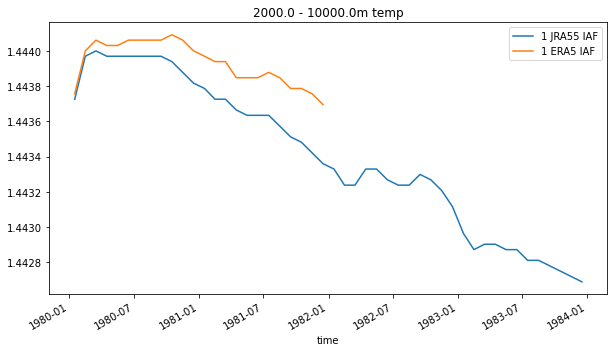

In [16]:
%%time
keys = exptdict.keys()
plot_depthintv('temp',[2000.,10000.],keys=keys)

## Surface properties

Text(0.5, 1.0, 'ERA-5 - JRA-55 SSS (psu)')

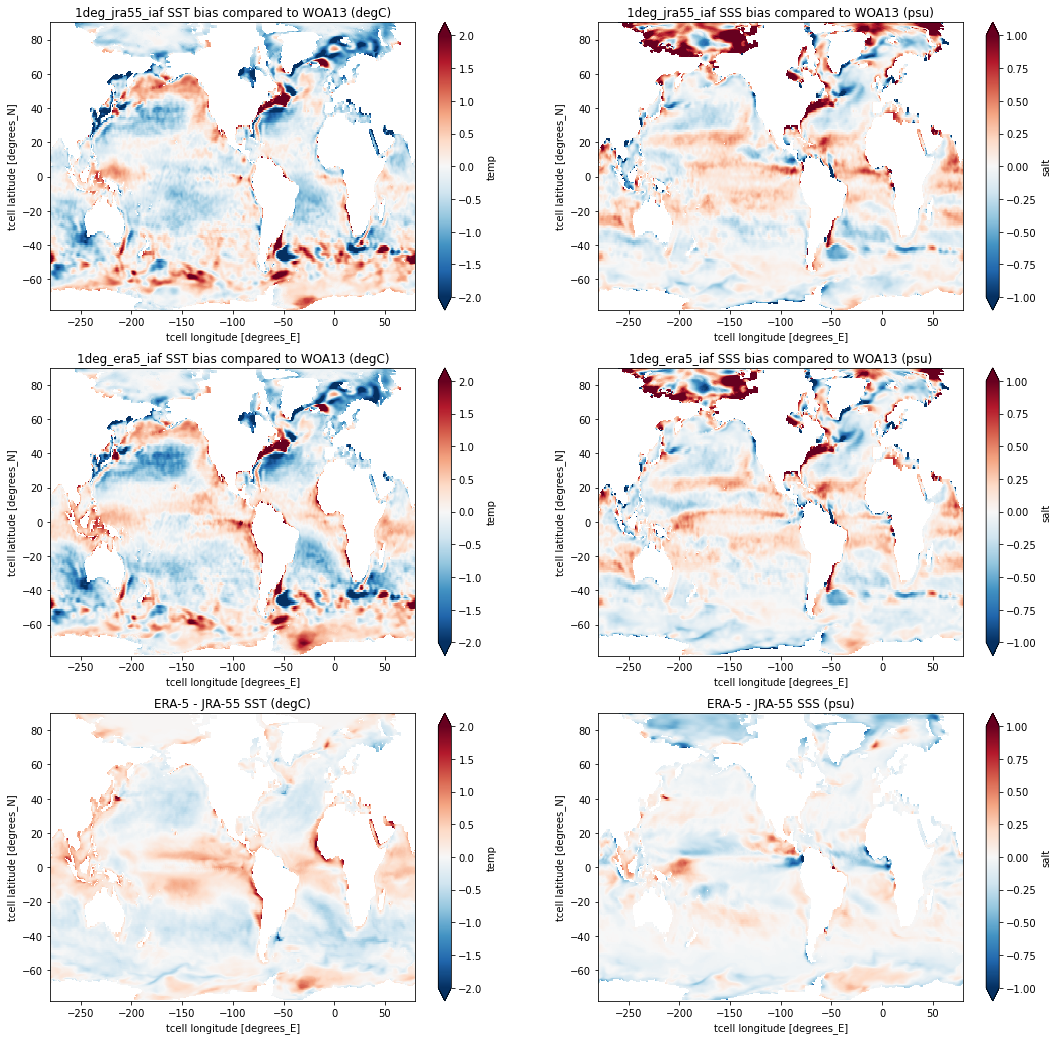

In [18]:
keys = exptdict.keys()
times = ['1981-01-01','1982-01-01']
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(18,18))
sst = {}
sss = {}
for i, ekey in enumerate(keys):
    expt = exptdict[ekey]['expt']
    sst[ekey] = cc.querying.getvar(expt,'temp',session).isel(st_ocean=0).sel(time=slice(times[0],times[1])).mean('time')-273.15
    sss[ekey] = cc.querying.getvar(expt,'salt',session).isel(st_ocean=0).sel(time=slice(times[0],times[1])).mean('time')
    
    
    sst_bias = sst[ekey] - WOA13.temp.isel(ZT=0).mean('time').values
    sss_bias = sss[ekey] - WOA13.salt.isel(ZT=0).mean('time').values
    sst_bias.plot(ax=axes[i][0],vmin=-2.,vmax=2.,cmap='RdBu_r')
    axes[i][0].set_title(expt + ' SST bias compared to WOA13 (degC)')
    sss_bias.plot(ax=axes[i][1],vmin=-1.,vmax=1.,cmap='RdBu_r')
    axes[i][1].set_title(expt + ' SSS bias compared to WOA13 (psu)')
    
(sst['1 ERA5 IAF']-sst['1 JRA55 IAF']).plot(ax=axes[i+1][0],vmin=-2.,vmax=2.,cmap='RdBu_r')
axes[i+1][0].set_title('ERA-5 - JRA-55 SST (degC)')
(sss['1 ERA5 IAF']-sss['1 JRA55 IAF']).plot(ax=axes[i+1][1],vmin=-1.,vmax=1.,cmap='RdBu_r')
axes[i+1][1].set_title('ERA-5 - JRA-55 SSS (psu)')

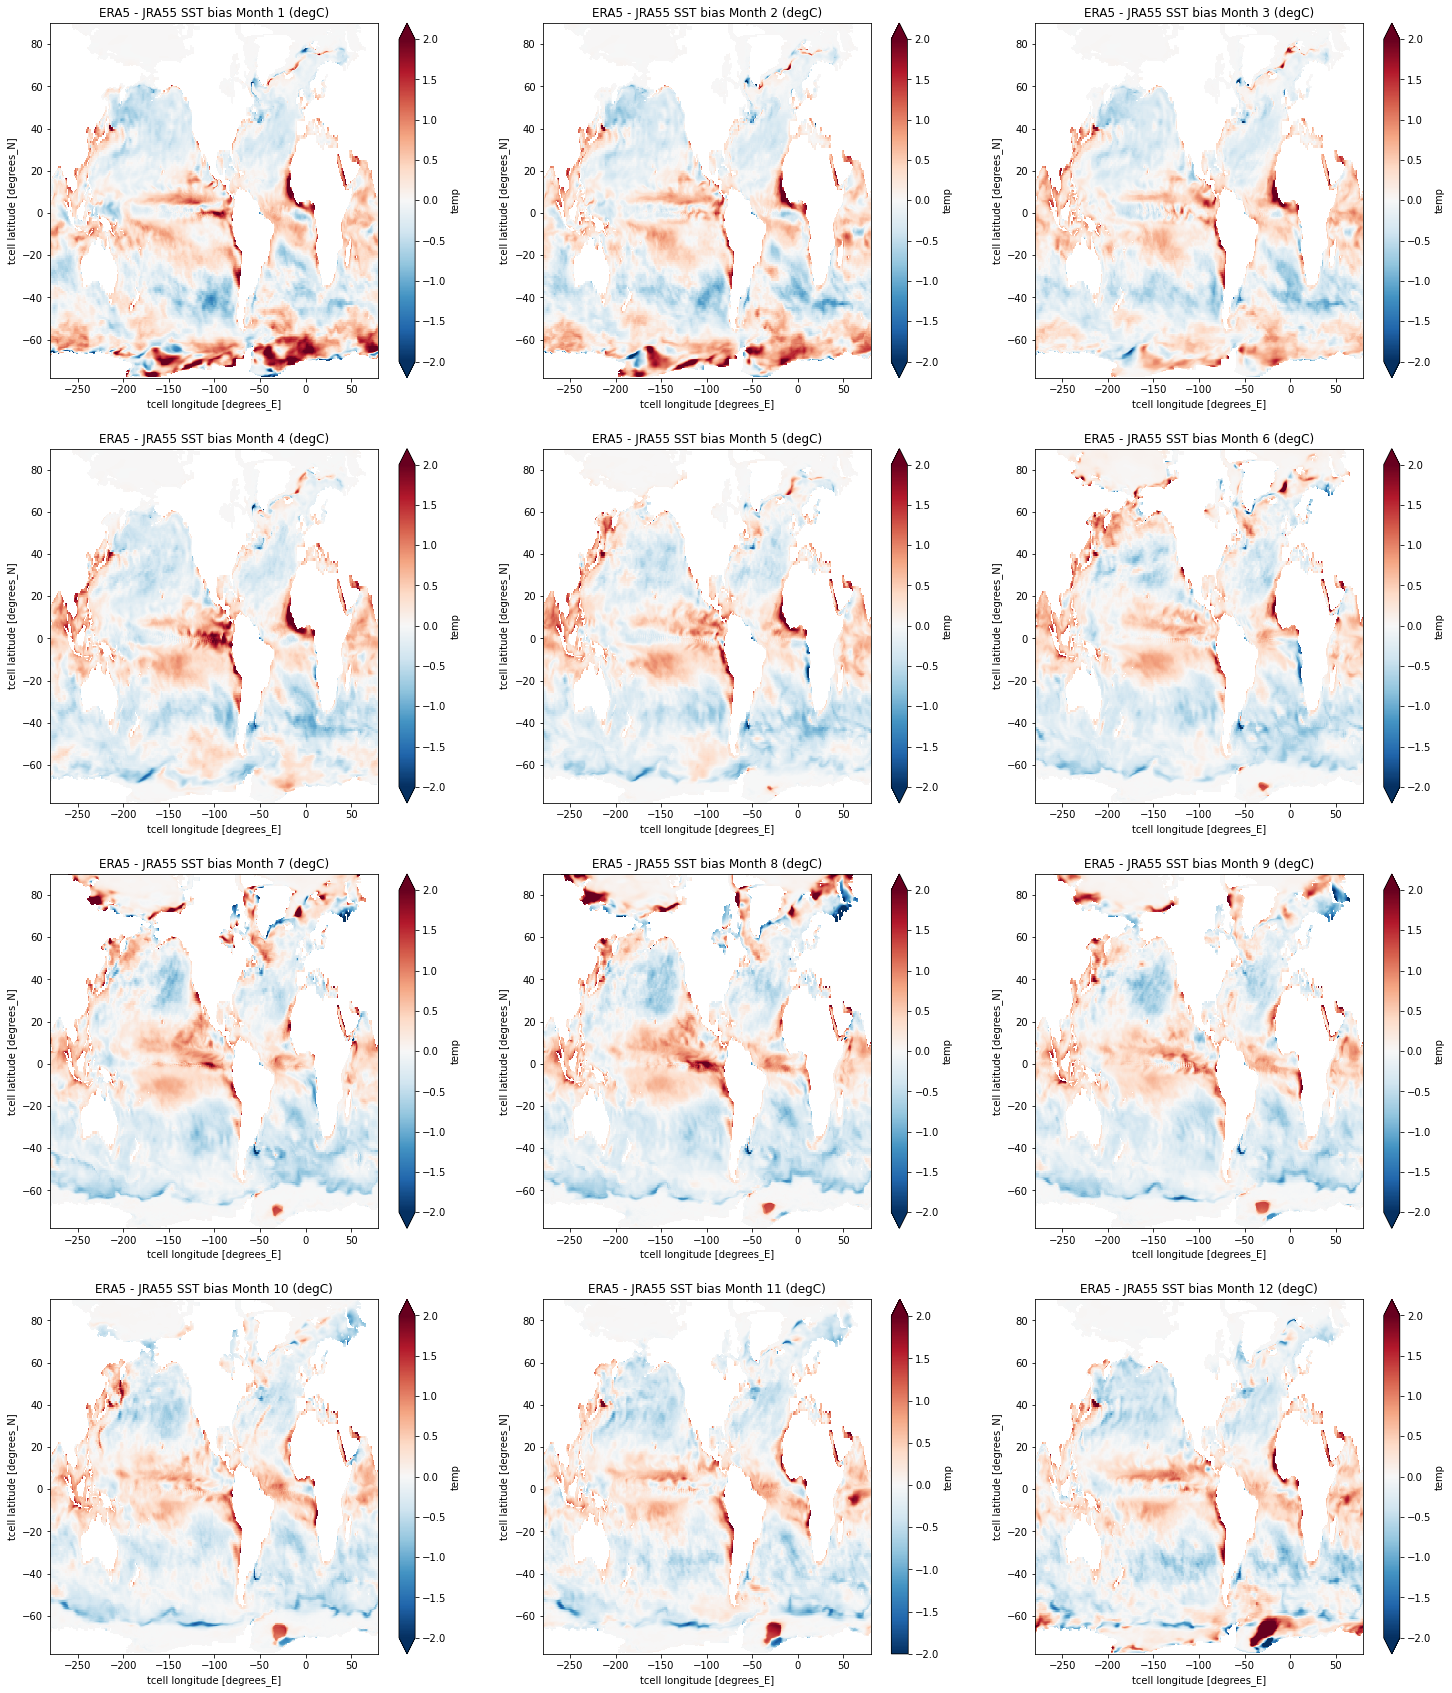

In [20]:
# Seasonal SST differences:
keys = exptdict.keys()
year = '1981'
fig, axes = plt.subplots(nrows=4,ncols=3,figsize=(25,30))
axs = axes.reshape(-1)
for i in range(12):
    ERAexpt = exptdict['1 ERA5 IAF']['expt']
    JRAexpt = exptdict['1 JRA55 IAF']['expt']
    sstERA = cc.querying.getvar(ERAexpt,'temp',session).isel(st_ocean=0).sel(time=slice(year + '-01-01',year + '-12-31')).isel(time=i)
    sstJRA = cc.querying.getvar(JRAexpt,'temp',session).isel(st_ocean=0).sel(time=slice(year + '-01-01',year + '-12-31')).isel(time=i)
    
    (sstERA-sstJRA).plot(ax=axs[i],vmin=-2.,vmax=2.,cmap='RdBu_r')
    axs[i].set_title('ERA5 - JRA55 SST bias Month ' + str(i+1) + ' (degC)')

## Circulation Diagnostics

### Drake Passage Transport

1deg_jra55_iaf
1deg_era5_iaf
CPU times: user 1.84 s, sys: 233 ms, total: 2.07 s
Wall time: 2.53 s


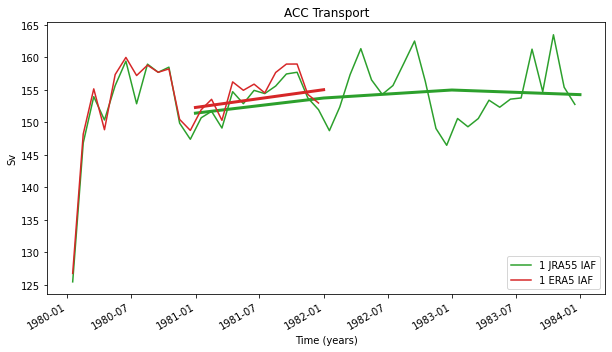

In [21]:
%%time

xmin=-69.9
ymin=-71.6
ymax=-51.0

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session)
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean')/1e6/1036
    DP.plot(label=ekey,color=exptdict[ekey]['color'])
    DP.resample(time='Y').mean().plot(color=exptdict[ekey]['color'],linewidth=3.)
plt.title("ACC Transport")
plt.xlabel('Time (years)')
plt.ylabel('Sv')
plt.legend()

### AABW overturning circulation @ 55°S

1deg_jra55_iaf
1deg_era5_iaf
CPU times: user 11.7 s, sys: 1.08 s, total: 12.8 s
Wall time: 13.9 s


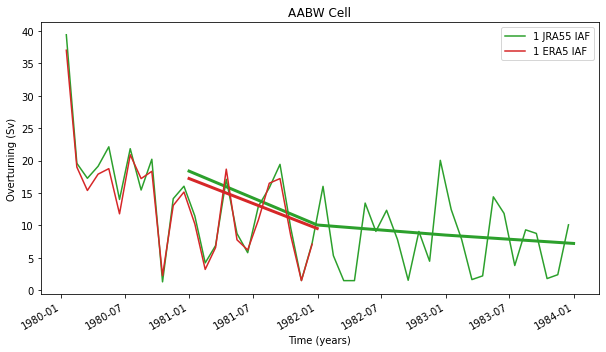

In [22]:
%%time
latitude=-55
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_aabw_gm = var2.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_aabw_sum = psi_aabw_sum + psi_aabw_gm
    except:
        print('GM term not found')
    
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho')
    psi_aabw_sum.plot(label=ekey,color=exptdict[ekey]['color'])
    psi_aabw_sum.resample(time='Y').mean().plot(color=exptdict[ekey]['color'],linewidth=3.)
plt.title('AABW Cell')
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()

## AABW overturning at 30S:

1deg_jra55_iaf
1deg_era5_iaf
CPU times: user 11.8 s, sys: 1.06 s, total: 12.8 s
Wall time: 13.7 s


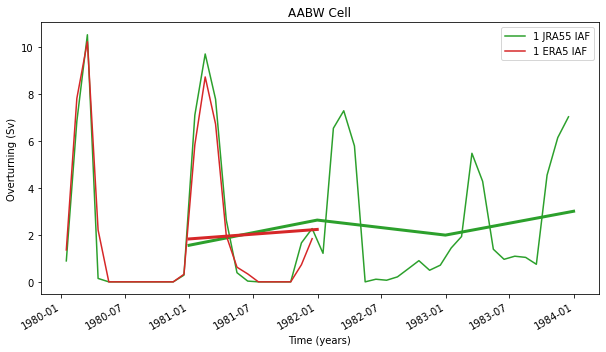

In [23]:
%%time
latitude=-30
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_aabw_gm = var2.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_aabw_sum = psi_aabw_sum + psi_aabw_gm
    except:
        print('GM term not found')
    
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho')
    psi_aabw_sum.plot(label=ekey,color=exptdict[ekey]['color'])
    psi_aabw_sum.resample(time='Y').mean().plot(color=exptdict[ekey]['color'],linewidth=3.)
plt.title('AABW Cell')
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()

### AMOC Overturning in density space @ 26°N

1deg_jra55_iaf
1deg_era5_iaf
CPU times: user 9.9 s, sys: 828 ms, total: 10.7 s
Wall time: 11.6 s


Text(0.5, 1.0, 'AMOC (rho) at 26N')

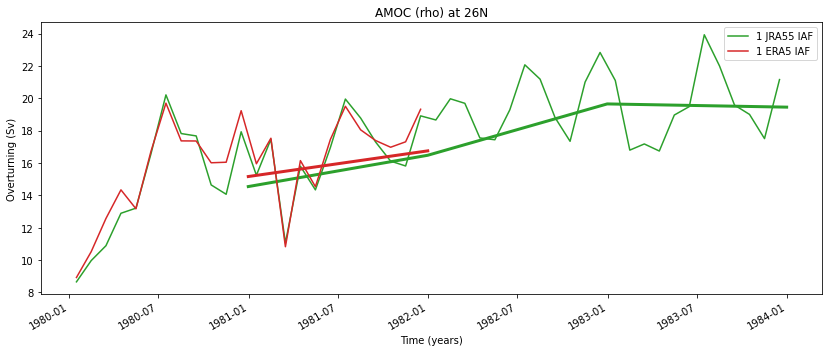

In [24]:
%%time
keys = exptdict.keys()
plt.figure(figsize=(14,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho')
    psi_amoc_sum.plot(label=ekey,color=exptdict[ekey]['color'])
    psi_amoc_sum.resample(time='Y').mean().plot(color=exptdict[ekey]['color'],linewidth=3.)

#    psi_amoc_sum.plot(label=ekey)#,)
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()
plt.title('AMOC (rho) at 26N')

## AMOC Overturning at 20S

1deg_jra55_iaf
1deg_era5_iaf
CPU times: user 9.5 s, sys: 750 ms, total: 10.3 s
Wall time: 10.8 s


Text(0.5, 1.0, 'AMOC (rho) at 30S')

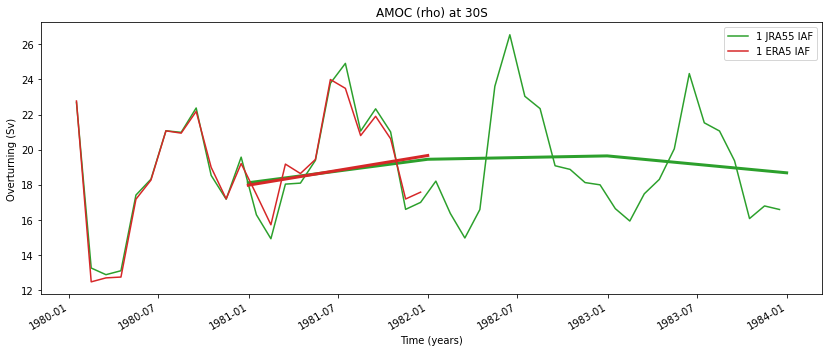

In [25]:
%%time
keys = exptdict.keys()
plt.figure(figsize=(14,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi_amoc = var.sel(grid_xt_ocean=slice(-60,20.)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=-30)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-60,20.)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=-30)*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho')
    psi_amoc_sum.plot(label=ekey,color=exptdict[ekey]['color'])
    psi_amoc_sum.resample(time='Y').mean().plot(color=exptdict[ekey]['color'],linewidth=3.)
    
#    psi_amoc_sum.plot(label=ekey)#,)
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()
plt.title('AMOC (rho) at 30S')

## NADW formation

1deg_jra55_iaf
1deg_era5_iaf
CPU times: user 12.3 s, sys: 986 ms, total: 13.2 s
Wall time: 13.9 s


Text(0.5, 1.0, 'AMOC (rho) formation 40-70N')

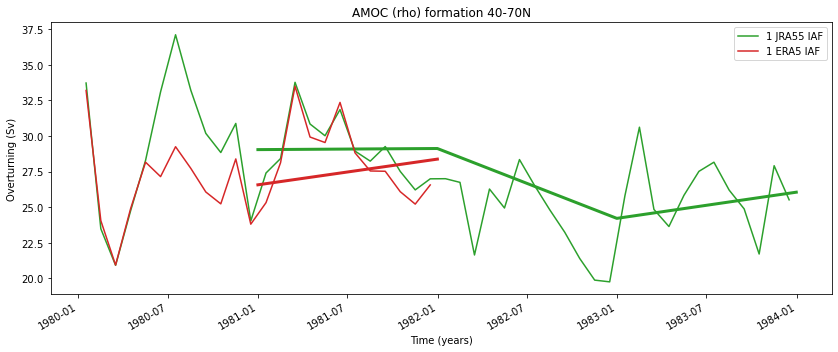

In [26]:
%%time
keys = exptdict.keys()
plt.figure(figsize=(14,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi_amoc = var.sum('grid_xt_ocean').sel(grid_yu_ocean=slice(50.,60.))*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_amoc_gm = var2.sum('grid_xt_ocean').sel(grid_yu_ocean=slice(50.,60.))*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').max('grid_yu_ocean')
    psi_amoc_sum.plot(label=ekey,color=exptdict[ekey]['color'])
    psi_amoc_sum.resample(time='Y').mean().plot(color=exptdict[ekey]['color'],linewidth=3.)
    
#    psi_amoc_sum.plot(label=ekey)#,)
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()
plt.title('AMOC (rho) formation 40-70N')

## Global Overturning Streamfunction (density)

In [27]:
def plot_psi(psi_avg, clev=np.arange(-25,25,1.)):    
    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1032))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

1deg_jra55_iaf
1deg_era5_iaf


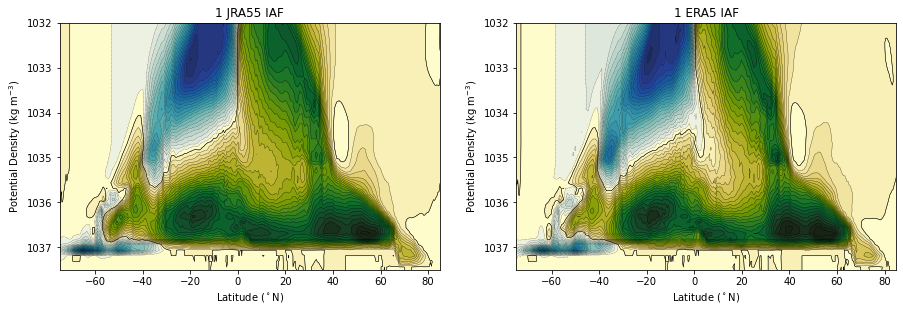

In [28]:
plt.figure(figsize=(15,10))
ii=0
keys = exptdict.keys()
for ekey in keys:
    ii+=1
    plt.subplot(2,2,ii)
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi = var.mean('time').sum('grid_xt_ocean')*1.0e-9
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_gm = var2.mean('time').sum('grid_xt_ocean')*1.0e-9
        psi_avg = psi_avg + psi_gm
    except:
        print('GM term not found')
        
    psi_avg.load()
    p1 = plot_psi(psi_avg)
    plt.title(ekey)

1deg_jra55_iaf
1deg_era5_iaf


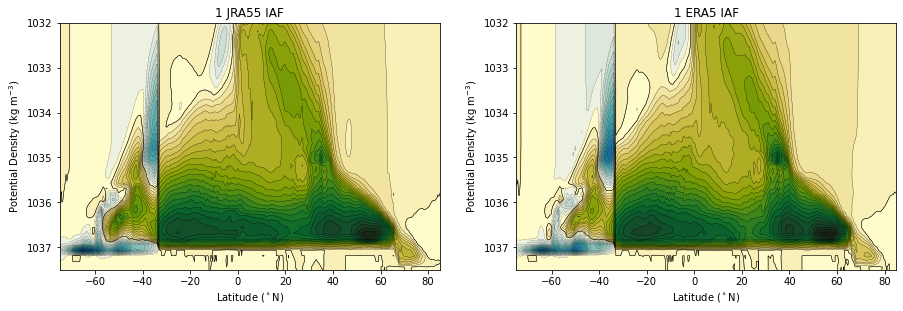

In [29]:
# Atlantic mask:
plt.figure(figsize=(15,10))
ii=0
keys = exptdict.keys()
for ekey in keys:
    ii+=1
    plt.subplot(2,2,ii)
    expt = exptdict[ekey]['expt']
    print(expt)
    
    # Atlantic mask:
    ht = cc.querying.getvar(expt,'ht',session,n=-1)
    land_mask = ~ht.isnull()
    
    ## create masks out of the above chunks
    south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0) 
    indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
    indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
    indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
    indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
    indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
    indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
    indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
    atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
    atlantic_sector_map = atlantic_sector_map + south_map
    atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)

    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi = var
    atlantic_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
    atlantic_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
    atlantic_sector_mask = atlantic_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})
    psi = (psi*atlantic_sector_mask).sum('grid_xt_ocean').mean('time')*1.0e-9
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_gm = var2.mean('time').sum('grid_xt_ocean')*1.0e-9
        psi_avg = psi_avg + psi_gm
    except:
        print('GM term not found')
        
    psi_avg.load()
    p1 = plot_psi(psi_avg)
    plt.title(ekey)

### Ice Area (in both hemispheres)

1deg_jra55_iaf
1deg_era5_iaf


Text(0.5, 1.0, 'Southern Ocean')

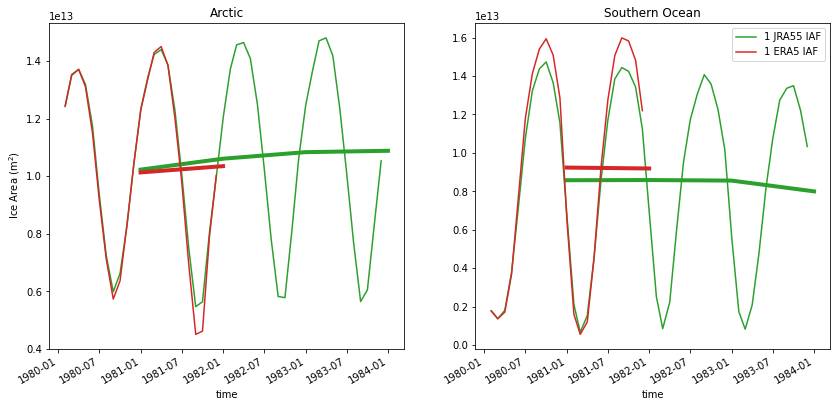

In [30]:
variable='aice_m'
fig,axes = plt.subplots(1,2,figsize=(14,6))
keys = exptdict.keys()
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean')
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean')
    
    
    NH_area.isel(time=slice(0,-1)).plot(ax=axes[0],label=ekey,color=exptdict[ekey]['color'])
    SH_area.isel(time=slice(0,-1)).plot(ax=axes[1],label=ekey,color=exptdict[ekey]['color']) 
    NH_area.isel(time=slice(0,-1)).resample(time='Y').mean().plot(ax=axes[0],color=exptdict[ekey]['color'],linewidth=4.)
    SH_area.isel(time=slice(0,-1)).resample(time='Y').mean().plot(ax=axes[1],color=exptdict[ekey]['color'],linewidth=4.)
    
axes[0].set_ylabel(' Ice Area (m$^2$)')
axes[1].legend()
axes[0].set_title('Arctic')
axes[1].set_title('Southern Ocean')

1deg_jra55_iaf
1deg_era5_iaf


Text(0.5, 1.0, 'Southern Ocean')

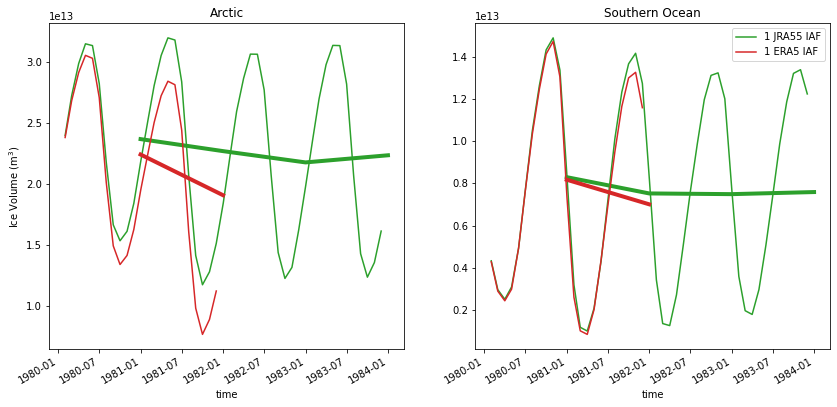

In [31]:
variable='vicen_m'
fig,ax = plt.subplots(1,2,figsize=(14,6))
keys = exptdict.keys()
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    vol = var*area_t
    vol_zonalsum = vol.sum('xt_ocean').sum('nc')
    NH_vol = vol_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean')
    NH_vol.isel(time=slice(0,-1)).plot(ax=ax[0],label=ekey,color=exptdict[ekey]['color'])
    NH_vol.isel(time=slice(0,-1)).resample(time='Y').mean().plot(ax=ax[0],color=exptdict[ekey]['color'],linewidth=4.)
    SH_vol = vol_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean')
    SH_vol.isel(time=slice(0,-1)).plot(ax=ax[1],label=ekey,color=exptdict[ekey]['color'])
    SH_vol.isel(time=slice(0,-1)).resample(time='Y').mean().plot(ax=ax[1],color=exptdict[ekey]['color'],linewidth=4.)
 
ax[0].set_ylabel('Ice Volume (m$^3$)')
ax[1].legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')